# Contextualized Bayesian Networks

For more details, please see the [NOTMAD preprint](https://arxiv.org/abs/2111.01104).

# Factor Graphs
To improve scalability, we can include factor graphs (low-dimensional axes of network variation).
This is controlled by the `num_factors` parameter. The default value of 0 turns off factor graphs and computes the network in full dimensionality.

In [1]:
import numpy as np
from contextualized.dags.graph_utils import simulate_linear_sem
n = 1000
C = np.linspace(1, 2, n).reshape((n, 1))
W = np.zeros((4, 4, n, 1))
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

In [2]:
%%capture
from contextualized.easy import ContextualizedBayesianNetworks

cbn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=2, num_factors=2,
    n_bootstraps=1, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
cbn.fit(C, X, max_epochs=10)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | encoder        | MLP       | 1.4 K 
1 | explainer      | Explainer | 8     
2 | factor_softmax | Softmax   | 0     
---------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change

In [3]:
cbn.models[-1].latent_dim

2

We can predict full-dimensional graphs or factor graphs based on the keyword argument `factors`:


In [4]:
predicted_networks = cbn.predict_networks(C)
print(predicted_networks.shape)

predicted_factor_networks = cbn.predict_networks(C, factors=True)
predicted_factor_networks.shape

/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 800it [00:00, ?it/s]

(1000, 4, 4)


Predicting: 800it [00:00, ?it/s]

(1000, 2, 2)

In [25]:
%%capture
from contextualized.easy import ContextualizedBayesianNetworks

mses = []
for n_factors in range(1, 5):
    cbn = ContextualizedBayesianNetworks(
        encoder_type='mlp', num_archetypes=2, num_factors=n_factors,
        n_bootstraps=1, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
        sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
        learning_rate=1e-3, foobar=None)
    cbn.fit(C, X, max_epochs=10)
    mses.append(np.mean(cbn.measure_mses(C, X)))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | encoder        | MLP       | 1.4 K 
1 | explainer      | Explainer | 2     
2 | factor_softmax | Softmax   | 0     
---------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type      | Params
---------------------------------------------
0 | encoder        | MLP       | 1.4 K 
1 | explainer      | Explainer | 8     
2 | factor_softmax | Softmax   | 0     
---------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.

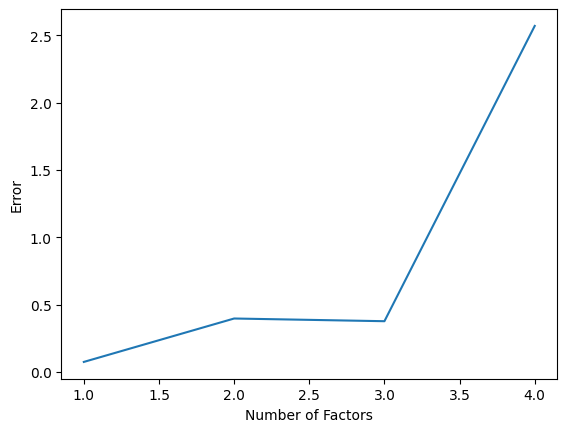

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 5), mses)
plt.ylabel("Error")
plt.xlabel("Number of Factors")
plt.show()